In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
from tqdm import tqdm_notebook as tqdm
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
import seaborn as sns
from torch.autograd import grad


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = '/content/drive/MyDrive/Dataset/'

In [ ]:
batch_size = 100
number_of_class = 5

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transforms.Compose([transforms.Resize(64), transforms.RandomHorizontalFlip(), transforms.CenterCrop(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True, num_workers=4)
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print(device)


cuda:0


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Weight initialization for Bias and Weights

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Generator(nn.Module):

    def __init__(self, nz=128, ngf=64, nc=3, n_class=number_of_class):
        super(Generator, self).__init__()
        self.ReLU = nn.ReLU(True)
        self.Tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(128+n_class, ngf * 8, 4, 1, 0, bias=False)
        self.BatchNorm1 = nn.BatchNorm2d(ngf * 8)
        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ngf * 4)
        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ngf * 2)
        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ngf * 1)
        self.conv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1, bias=False)
        self.apply(weights_init)

    def forward(self, input):
        x = self.conv1(input)
        x = self.BatchNorm1(x)
        x = self.ReLU(x)
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.ReLU(x)
        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.ReLU(x)
        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.conv5(x)
        output = self.Tanh(x)
        return output
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (ReLU): ReLU(inplace=True)
  (Tanh): Tanh()
  (conv1): ConvTranspose2d(133, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (BatchNorm1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ndf=64, nc=3, n_class=number_of_class):
        super(Discriminator, self).__init__()
        self.LeakyReLU = nn.LeakyReLU(0.2, inplace=True)
        self.conv1 = nn.Conv2d(nc, ndf, 4, 2, 1, bias=False)
        self.do = nn.Dropout(p=0.5)
        self.conv2 = nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False)
        self.BatchNorm2 = nn.BatchNorm2d(ndf * 2)
        self.conv3 = nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False)
        self.BatchNorm3 = nn.BatchNorm2d(ndf * 4)
        self.conv4 = nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False)
        self.BatchNorm4 = nn.BatchNorm2d(ndf * 8)
        self.conv5 = nn.Conv2d(ndf * 8, ndf * 1, 4, 1, 0, bias=False)
        self.disc_linear = nn.Linear(ndf * 1, 1)
        self.aux_linear = nn.Linear(ndf * 1, n_class)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.ndf = ndf
        self.apply(weights_init)

    def forward(self, input):
        x = self.conv1(input)
        x = self.do(x)
        x = self.LeakyReLU(x)
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.do(x)
        x = self.LeakyReLU(x)
        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.do(x)
        x = self.LeakyReLU(x)
        x = self.conv4(x)
        x = self.BatchNorm4(x)
        x = self.do(x)
        x = self.LeakyReLU(x)
        x = self.conv5(x)
        x = x.view(-1, self.ndf * 1)
        c = self.aux_linear(x)
        c = self.softmax(c)
        s = self.disc_linear(x)
        s = self.sigmoid(s)
        return s,c

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)


Discriminator(
  (LeakyReLU): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (do): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (BatchNorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (disc_linear): Linear(in_features=64, out_features=1, bias=True)
  (aux_linear): Linear(in_features=64, out_features=5, bias=True)
  (softmax): Softmax(dim=None)

In [ ]:
optimizerD = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
s_criterion = nn.BCELoss()
c_criterion = nn.NLLLoss()
r_label = 0.7
f_label = 0

In [ ]:
def truncated_normal(size, threshold=1):
    values = truncnorm.rvs(-threshold, threshold, size=size)
    return values
    
def show_generated_img(num_show):
    gen_images = []
    for _ in range(num_show):
        noise = torch.randn(1, 128, 1, 1, device=device)
        pic_label = torch.randint(0, number_of_class, (1, ), device=device)
        gen_image = concat_noise_label(noise, pic_label, device)
        gen_image = generator(gen_image).to("cpu").clone().detach().squeeze(0)
        gen_image = gen_image.numpy().transpose(1, 2, 0)
        gen_images.append(gen_image)
        
    fig = plt.figure(figsize=(10, 5))
    for i, gen_image in enumerate(gen_images):
        ax = fig.add_subplot(1, num_show, i + 1, xticks=[], yticks=[])
        plt.imshow(gen_image + 1 / 2)
    plt.show()
    
def show_loss(ylim): 
    sns.set_style("white")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Generator and Discrimination Loss")
    ax.plot(Gen_losses,label="Generator",c="b")
    ax.plot(Dis_losses,label="Discriminator",c="r")
    ax.set_xlabel("epoch")
    ax.set_ylabel("Loss")
    ax.legend()
    if ylim == True:
        ax.set_ylim(0,4)
    ax.set_xlim(0,100)
def show_acc(ylim): 
    sns.set_style("white")
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    ax.set_title("Generator and Discrimination ACC")
    ax.plot(Gen_acc,label="Generator",c="b")
    ax.plot(Dis_acc,label="Discriminator",c="r")
    ax.set_xlabel("epoch")
    ax.set_ylabel("accuracy")
    ax.legend()
    if ylim == True:
        ax.set_ylim(0,1)
    ax.set_xlim(0,100)

In [ ]:
def onehot_encode(label, device, n_class=number_of_class):  
    eye = torch.eye(n_class, device=device) 
    return eye[label].view(-1, n_class, 1, 1)   
 
def concat_image_label(image, label, device, n_class=number_of_class):
    B, C, H, W = image.shape   
    oh_label = onehot_encode(label, device=device)
    oh_label = oh_label.expand(B, n_class, H, W)
    return torch.cat((image, oh_label), dim=1)
 
def concat_noise_label(noise, label, device):
    oh_label = onehot_encode(label, device=device)
    return torch.cat((noise, oh_label), dim=1)

In [ ]:
input = torch.tensor([batch_size, 3, 64, 64], device=device)
noise = torch.tensor([batch_size, 128, 1, 1], device=device)

fixed_noise = torch.randn(1, 128, 1, 1, device=device)
fixed_label = torch.randint(0, number_of_class, (1, ), device=device)
fixed_noise_label = concat_noise_label(fixed_noise, fixed_label, device)

Starting Training Loop...


<ipython-input-29-f9823965c8ea>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in enumerate(tqdm(dataloader)):


  0%|          | 0/11 [00:00<?, ?it/s]

<ipython-input-23-ea3bd92391a1>:48: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  c = self.softmax(c)


[1/100][11/11]
Loss_D: 0.9177	Loss_G: 1.5956
D(x): 0.6452	D(G(z)): 0.1298 / 0.1313


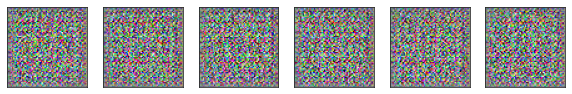

  0%|          | 0/11 [00:00<?, ?it/s]

[2/100][11/11]
Loss_D: 0.7892	Loss_G: 1.6800
D(x): 0.7913	D(G(z)): 0.0860 / 0.1277


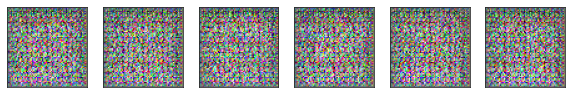

  0%|          | 0/11 [00:00<?, ?it/s]

[3/100][11/11]
Loss_D: 0.8230	Loss_G: 1.9097
D(x): 0.5895	D(G(z)): 0.1433 / 0.0528


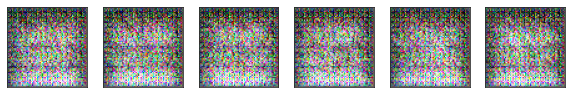

  0%|          | 0/11 [00:00<?, ?it/s]

[4/100][11/11]
Loss_D: 0.8258	Loss_G: 2.3859
D(x): 0.7629	D(G(z)): 0.1381 / 0.0368


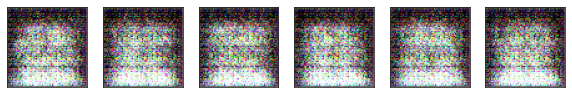

  0%|          | 0/11 [00:00<?, ?it/s]

[5/100][11/11]
Loss_D: 1.1023	Loss_G: 1.9361
D(x): 0.6348	D(G(z)): 0.1344 / 0.0585


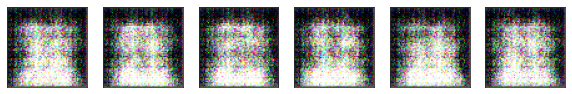

  0%|          | 0/11 [00:00<?, ?it/s]

[6/100][11/11]
Loss_D: 0.8972	Loss_G: 1.5859
D(x): 0.5456	D(G(z)): 0.0537 / 0.1026


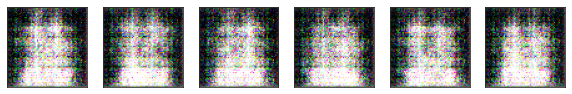

  0%|          | 0/11 [00:00<?, ?it/s]

[7/100][11/11]
Loss_D: 1.0150	Loss_G: 1.5070
D(x): 0.6797	D(G(z)): 0.1902 / 0.0764


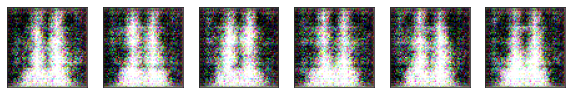

  0%|          | 0/11 [00:00<?, ?it/s]

[8/100][11/11]
Loss_D: 1.0071	Loss_G: 0.8254
D(x): 0.5235	D(G(z)): 0.1251 / 0.2215


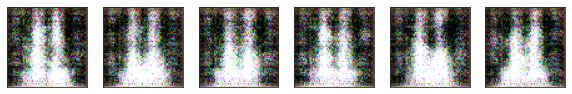

  0%|          | 0/11 [00:00<?, ?it/s]

[9/100][11/11]
Loss_D: 1.0107	Loss_G: 2.6400
D(x): 0.6143	D(G(z)): 0.2267 / 0.0387


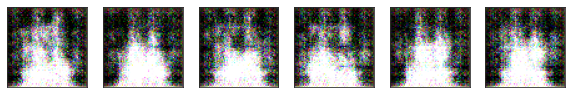

  0%|          | 0/11 [00:00<?, ?it/s]

[10/100][11/11]
Loss_D: 1.1396	Loss_G: 1.7323
D(x): 0.2825	D(G(z)): 0.0343 / 0.0803


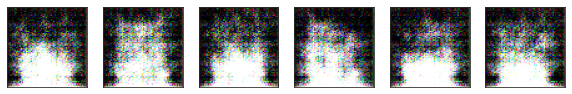

  0%|          | 0/11 [00:00<?, ?it/s]

[11/100][11/11]
Loss_D: 1.1880	Loss_G: 2.1869
D(x): 0.5843	D(G(z)): 0.1638 / 0.0386


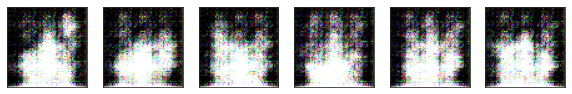

  0%|          | 0/11 [00:00<?, ?it/s]

[12/100][11/11]
Loss_D: 0.8335	Loss_G: 2.2640
D(x): 0.6177	D(G(z)): 0.0593 / 0.0470


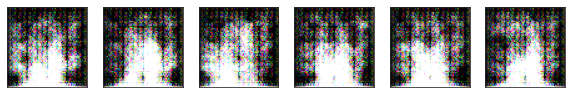

  0%|          | 0/11 [00:00<?, ?it/s]

[13/100][11/11]
Loss_D: 0.7991	Loss_G: 3.0046
D(x): 0.5828	D(G(z)): 0.0256 / 0.0170


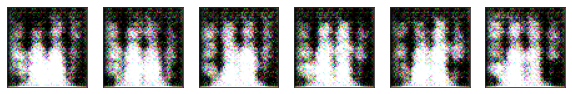

  0%|          | 0/11 [00:00<?, ?it/s]

[14/100][11/11]
Loss_D: 1.1475	Loss_G: 2.1485
D(x): 0.7679	D(G(z)): 0.2769 / 0.0283


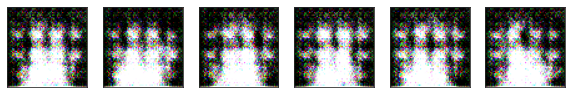

  0%|          | 0/11 [00:00<?, ?it/s]

[15/100][11/11]
Loss_D: 0.7567	Loss_G: 2.7781
D(x): 0.6693	D(G(z)): 0.0818 / 0.0236


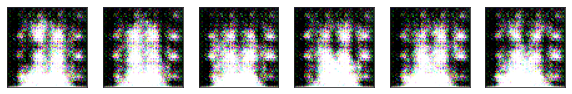

  0%|          | 0/11 [00:00<?, ?it/s]

[16/100][11/11]
Loss_D: 0.7799	Loss_G: 2.8311
D(x): 0.6535	D(G(z)): 0.0528 / 0.0142


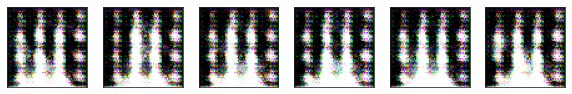

  0%|          | 0/11 [00:00<?, ?it/s]

[17/100][11/11]
Loss_D: 0.8698	Loss_G: 1.9306
D(x): 0.4606	D(G(z)): 0.0263 / 0.0658


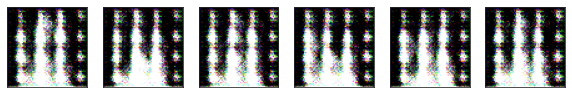

  0%|          | 0/11 [00:00<?, ?it/s]

[18/100][11/11]
Loss_D: 0.8004	Loss_G: 2.1064
D(x): 0.5992	D(G(z)): 0.0617 / 0.0319


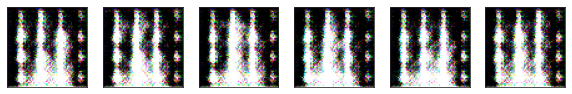

  0%|          | 0/11 [00:00<?, ?it/s]

[19/100][11/11]
Loss_D: 0.6805	Loss_G: 2.4901
D(x): 0.7119	D(G(z)): 0.0151 / 0.0428


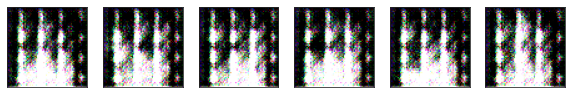

  0%|          | 0/11 [00:00<?, ?it/s]

[20/100][11/11]
Loss_D: 0.7139	Loss_G: 1.2795
D(x): 0.7042	D(G(z)): 0.0506 / 0.1095


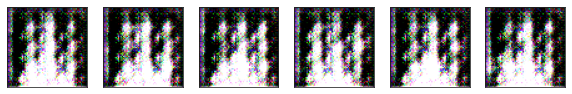

  0%|          | 0/11 [00:00<?, ?it/s]

[21/100][11/11]
Loss_D: 0.7931	Loss_G: 2.4099
D(x): 0.8241	D(G(z)): 0.0686 / 0.0136


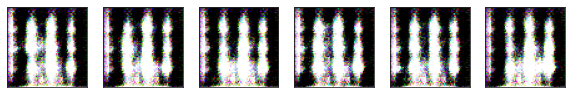

  0%|          | 0/11 [00:00<?, ?it/s]

[22/100][11/11]
Loss_D: 1.0177	Loss_G: 2.3982
D(x): 0.6295	D(G(z)): 0.1338 / 0.0206


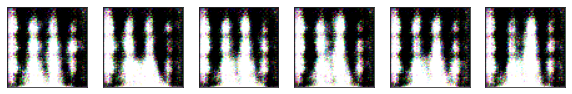

  0%|          | 0/11 [00:00<?, ?it/s]

[23/100][11/11]
Loss_D: 0.7405	Loss_G: 2.7654
D(x): 0.8139	D(G(z)): 0.0668 / 0.0170


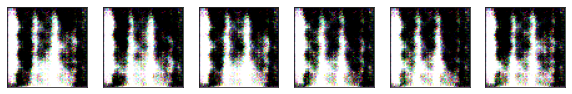

  0%|          | 0/11 [00:00<?, ?it/s]

[24/100][11/11]
Loss_D: 0.8023	Loss_G: 1.9404
D(x): 0.6997	D(G(z)): 0.0508 / 0.0903


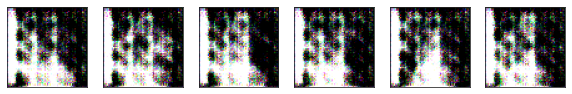

  0%|          | 0/11 [00:00<?, ?it/s]

[25/100][11/11]
Loss_D: 0.8870	Loss_G: 1.4666
D(x): 0.5586	D(G(z)): 0.1422 / 0.0627


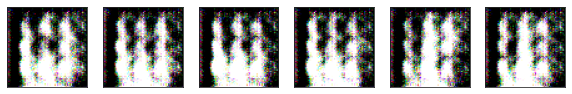

  0%|          | 0/11 [00:00<?, ?it/s]

[26/100][11/11]
Loss_D: 1.2203	Loss_G: 0.4236
D(x): 0.2286	D(G(z)): 0.0236 / 0.3264


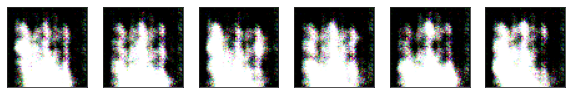

  0%|          | 0/11 [00:00<?, ?it/s]

[27/100][11/11]
Loss_D: 0.9431	Loss_G: 1.8081
D(x): 0.6084	D(G(z)): 0.2307 / 0.0262


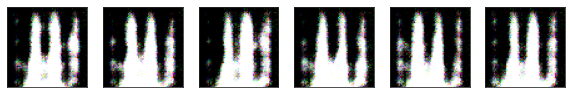

  0%|          | 0/11 [00:00<?, ?it/s]

[28/100][11/11]
Loss_D: 0.6685	Loss_G: 0.7746
D(x): 0.5889	D(G(z)): 0.0272 / 0.1089


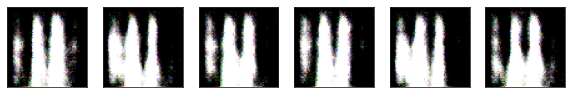

  0%|          | 0/11 [00:00<?, ?it/s]

[29/100][11/11]
Loss_D: 0.9015	Loss_G: 3.4029
D(x): 0.7050	D(G(z)): 0.0436 / 0.0055


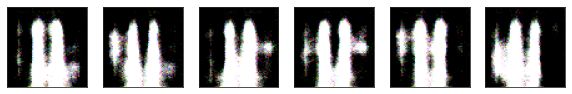

  0%|          | 0/11 [00:00<?, ?it/s]

[30/100][11/11]
Loss_D: 0.9100	Loss_G: 1.9045
D(x): 0.5397	D(G(z)): 0.1148 / 0.0256


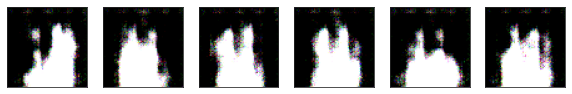

  0%|          | 0/11 [00:00<?, ?it/s]

[31/100][11/11]
Loss_D: 1.1396	Loss_G: 0.1819
D(x): 0.2859	D(G(z)): 0.1228 / 0.2441


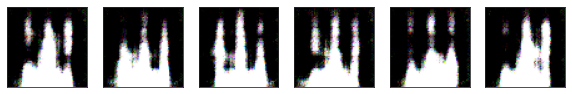

  0%|          | 0/11 [00:00<?, ?it/s]

[32/100][11/11]
Loss_D: 0.8799	Loss_G: 1.2200
D(x): 0.5764	D(G(z)): 0.1522 / 0.0548


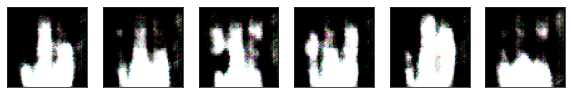

  0%|          | 0/11 [00:00<?, ?it/s]

[33/100][11/11]
Loss_D: 1.5524	Loss_G: -0.0421
D(x): 0.1571	D(G(z)): 0.1123 / 0.4092


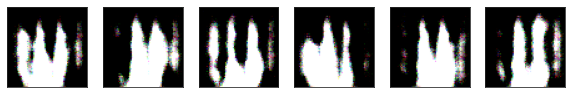

  0%|          | 0/11 [00:00<?, ?it/s]

[34/100][11/11]
Loss_D: 0.8933	Loss_G: 2.5450
D(x): 0.6170	D(G(z)): 0.1453 / 0.0230


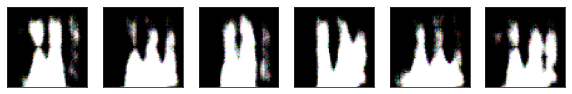

  0%|          | 0/11 [00:00<?, ?it/s]

[35/100][11/11]
Loss_D: 1.2173	Loss_G: 2.2471
D(x): 0.6567	D(G(z)): 0.2970 / 0.0189


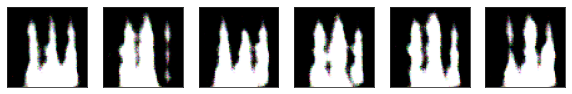

  0%|          | 0/11 [00:00<?, ?it/s]

[36/100][11/11]
Loss_D: 0.9663	Loss_G: 0.9867
D(x): 0.5416	D(G(z)): 0.2103 / 0.0907


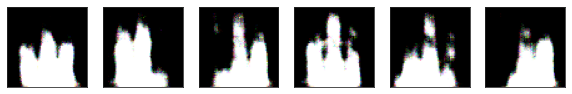

  0%|          | 0/11 [00:00<?, ?it/s]

[37/100][11/11]
Loss_D: 0.7188	Loss_G: 2.4236
D(x): 0.6242	D(G(z)): 0.0524 / 0.0188


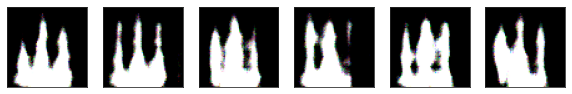

  0%|          | 0/11 [00:00<?, ?it/s]

[38/100][11/11]
Loss_D: 0.9277	Loss_G: 0.6751
D(x): 0.4826	D(G(z)): 0.1064 / 0.1273


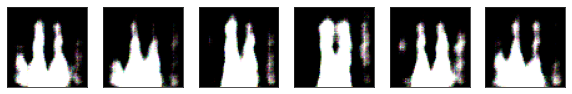

  0%|          | 0/11 [00:00<?, ?it/s]

[39/100][11/11]
Loss_D: 0.9834	Loss_G: 1.8380
D(x): 0.5377	D(G(z)): 0.1384 / 0.0253


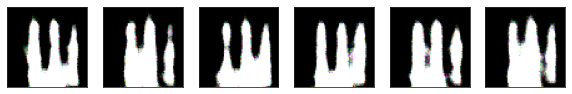

  0%|          | 0/11 [00:00<?, ?it/s]

[40/100][11/11]
Loss_D: 0.7646	Loss_G: 2.1243
D(x): 0.8187	D(G(z)): 0.0889 / 0.0168


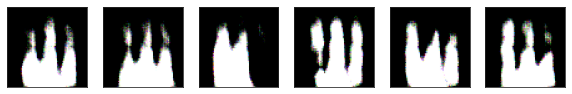

  0%|          | 0/11 [00:00<?, ?it/s]

[41/100][11/11]
Loss_D: 0.9700	Loss_G: 1.4793
D(x): 0.7111	D(G(z)): 0.1537 / 0.0329


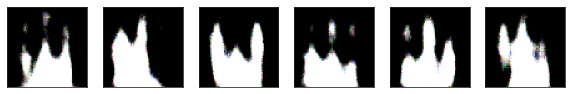

  0%|          | 0/11 [00:00<?, ?it/s]

[42/100][11/11]
Loss_D: 0.8686	Loss_G: 1.9800
D(x): 0.6875	D(G(z)): 0.1867 / 0.0255


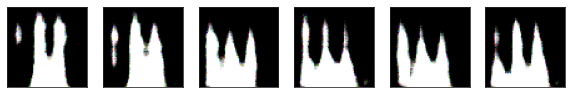

  0%|          | 0/11 [00:00<?, ?it/s]

[43/100][11/11]
Loss_D: 0.9838	Loss_G: 1.0281
D(x): 0.4948	D(G(z)): 0.1988 / 0.0747


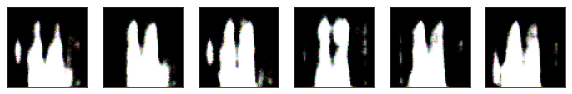

  0%|          | 0/11 [00:00<?, ?it/s]

[44/100][11/11]
Loss_D: 1.1051	Loss_G: 1.4861
D(x): 0.8106	D(G(z)): 0.3076 / 0.0419


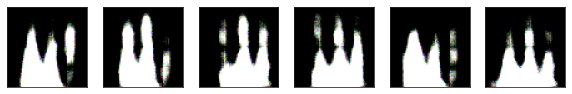

  0%|          | 0/11 [00:00<?, ?it/s]

[45/100][11/11]
Loss_D: 1.2219	Loss_G: 0.2845
D(x): 0.3820	D(G(z)): 0.1424 / 0.2028


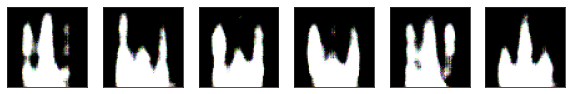

  0%|          | 0/11 [00:00<?, ?it/s]

[46/100][11/11]
Loss_D: 1.1416	Loss_G: 1.8449
D(x): 0.6007	D(G(z)): 0.3099 / 0.0273


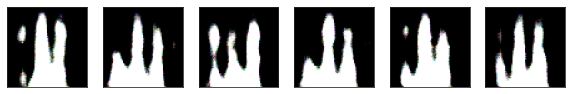

  0%|          | 0/11 [00:00<?, ?it/s]

[47/100][11/11]
Loss_D: 0.9469	Loss_G: 1.1066
D(x): 0.5529	D(G(z)): 0.0929 / 0.1102


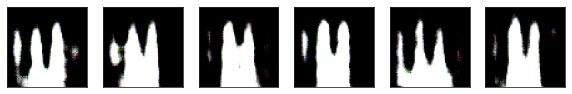

  0%|          | 0/11 [00:00<?, ?it/s]

[48/100][11/11]
Loss_D: 0.8052	Loss_G: 1.2050
D(x): 0.6740	D(G(z)): 0.1194 / 0.0985


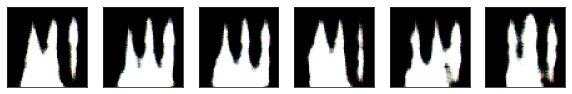

  0%|          | 0/11 [00:00<?, ?it/s]

[49/100][11/11]
Loss_D: 0.8719	Loss_G: 0.7652
D(x): 0.5570	D(G(z)): 0.0990 / 0.0915


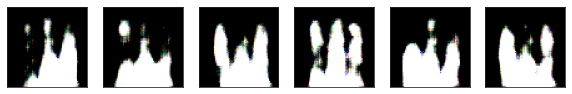

  0%|          | 0/11 [00:00<?, ?it/s]

[50/100][11/11]
Loss_D: 1.1153	Loss_G: -0.0213
D(x): 0.3918	D(G(z)): 0.0808 / 0.3926


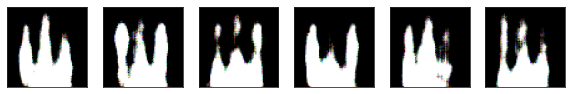

  0%|          | 0/11 [00:00<?, ?it/s]

[51/100][11/11]
Loss_D: 0.8056	Loss_G: 0.7768
D(x): 0.6733	D(G(z)): 0.0758 / 0.0902


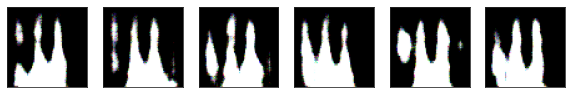

  0%|          | 0/11 [00:00<?, ?it/s]

[52/100][11/11]
Loss_D: 1.0217	Loss_G: 0.8598
D(x): 0.5715	D(G(z)): 0.1073 / 0.1482


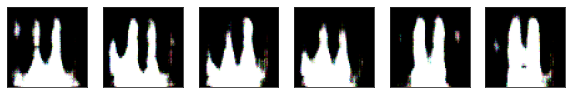

  0%|          | 0/11 [00:00<?, ?it/s]

[53/100][11/11]
Loss_D: 0.8181	Loss_G: 0.8075
D(x): 0.6004	D(G(z)): 0.0824 / 0.0935


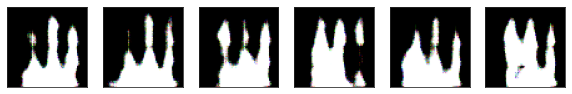

  0%|          | 0/11 [00:00<?, ?it/s]

[54/100][11/11]
Loss_D: 0.9154	Loss_G: 0.5787
D(x): 0.4732	D(G(z)): 0.1173 / 0.1990


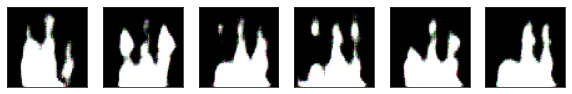

  0%|          | 0/11 [00:00<?, ?it/s]

[55/100][11/11]
Loss_D: 0.7779	Loss_G: 1.3269
D(x): 0.6440	D(G(z)): 0.0487 / 0.0511


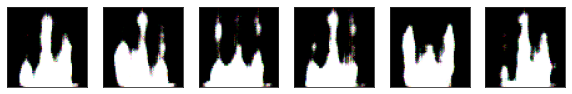

  0%|          | 0/11 [00:00<?, ?it/s]

[56/100][11/11]
Loss_D: 0.8215	Loss_G: 1.2656
D(x): 0.5841	D(G(z)): 0.0735 / 0.0529


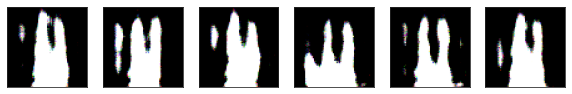

  0%|          | 0/11 [00:00<?, ?it/s]

[57/100][11/11]
Loss_D: 0.8095	Loss_G: 1.6277
D(x): 0.6606	D(G(z)): 0.1002 / 0.0357


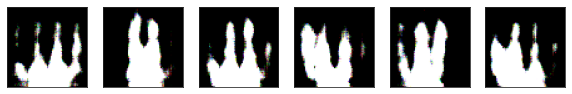

  0%|          | 0/11 [00:00<?, ?it/s]

[58/100][11/11]
Loss_D: 0.7703	Loss_G: 1.6832
D(x): 0.6722	D(G(z)): 0.0428 / 0.0372


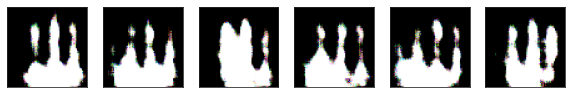

  0%|          | 0/11 [00:00<?, ?it/s]

[59/100][11/11]
Loss_D: 0.8067	Loss_G: 2.6136
D(x): 0.6762	D(G(z)): 0.0548 / 0.0171


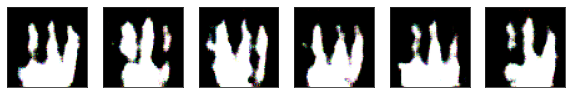

  0%|          | 0/11 [00:00<?, ?it/s]

[60/100][11/11]
Loss_D: 0.7808	Loss_G: 1.9118
D(x): 0.6240	D(G(z)): 0.1040 / 0.0252


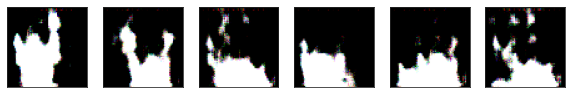

  0%|          | 0/11 [00:00<?, ?it/s]

[61/100][11/11]
Loss_D: 0.8068	Loss_G: 0.9245
D(x): 0.5244	D(G(z)): 0.0215 / 0.1204


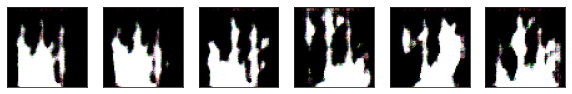

  0%|          | 0/11 [00:00<?, ?it/s]

[62/100][11/11]
Loss_D: 0.7841	Loss_G: 1.9630
D(x): 0.6730	D(G(z)): 0.0533 / 0.0220


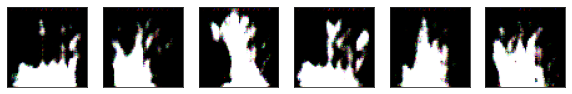

  0%|          | 0/11 [00:00<?, ?it/s]

[63/100][11/11]
Loss_D: 1.0672	Loss_G: 0.0226
D(x): 0.3598	D(G(z)): 0.0617 / 0.4058


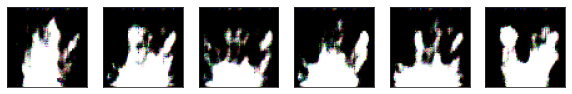

  0%|          | 0/11 [00:00<?, ?it/s]

[64/100][11/11]
Loss_D: 1.0558	Loss_G: 0.2701
D(x): 0.3210	D(G(z)): 0.0621 / 0.1840


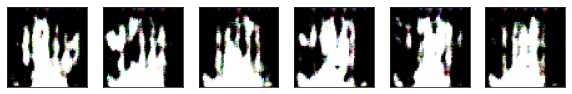

  0%|          | 0/11 [00:00<?, ?it/s]

[65/100][11/11]
Loss_D: 0.8716	Loss_G: 0.7465
D(x): 0.5182	D(G(z)): 0.0871 / 0.1271


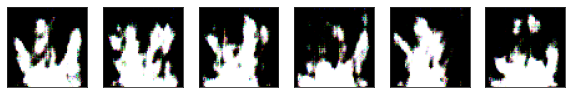

  0%|          | 0/11 [00:00<?, ?it/s]

[66/100][11/11]
Loss_D: 0.8237	Loss_G: 0.7195
D(x): 0.5002	D(G(z)): 0.0748 / 0.1600


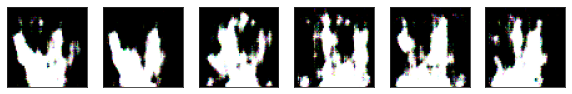

  0%|          | 0/11 [00:00<?, ?it/s]

[67/100][11/11]
Loss_D: 0.9093	Loss_G: 1.2035
D(x): 0.6164	D(G(z)): 0.1594 / 0.0782


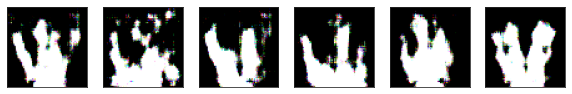

  0%|          | 0/11 [00:00<?, ?it/s]

[68/100][11/11]
Loss_D: 1.0519	Loss_G: 0.4235
D(x): 0.4109	D(G(z)): 0.1301 / 0.2413


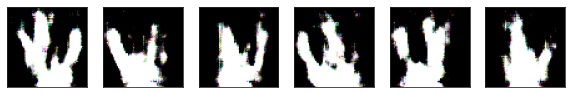

  0%|          | 0/11 [00:00<?, ?it/s]

[69/100][11/11]
Loss_D: 1.0092	Loss_G: -0.1162
D(x): 0.3320	D(G(z)): 0.0392 / 0.3731


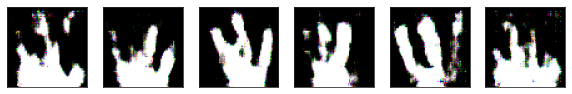

  0%|          | 0/11 [00:00<?, ?it/s]

[70/100][11/11]
Loss_D: 0.9303	Loss_G: 0.3466
D(x): 0.4121	D(G(z)): 0.0736 / 0.2276


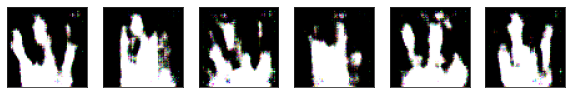

  0%|          | 0/11 [00:00<?, ?it/s]

[71/100][11/11]
Loss_D: 1.1276	Loss_G: 1.4978
D(x): 0.5611	D(G(z)): 0.2713 / 0.0445


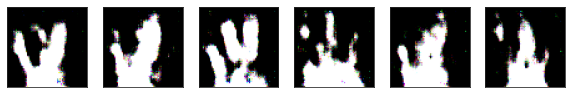

  0%|          | 0/11 [00:00<?, ?it/s]

[72/100][11/11]
Loss_D: 0.8902	Loss_G: 0.9684
D(x): 0.6451	D(G(z)): 0.1189 / 0.1941


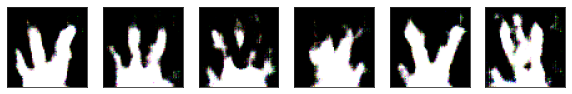

  0%|          | 0/11 [00:00<?, ?it/s]

[73/100][11/11]
Loss_D: 0.9606	Loss_G: 0.3453
D(x): 0.5023	D(G(z)): 0.1868 / 0.1871


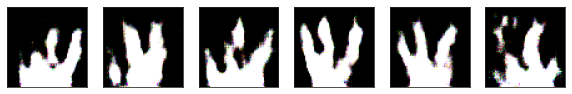

  0%|          | 0/11 [00:00<?, ?it/s]

[74/100][11/11]
Loss_D: 1.2205	Loss_G: 0.7632
D(x): 0.4742	D(G(z)): 0.2879 / 0.1055


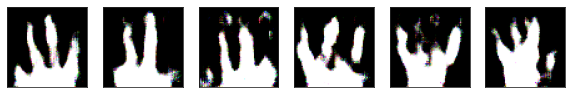

  0%|          | 0/11 [00:00<?, ?it/s]

[75/100][11/11]
Loss_D: 0.8710	Loss_G: 0.5887
D(x): 0.4709	D(G(z)): 0.1216 / 0.1574


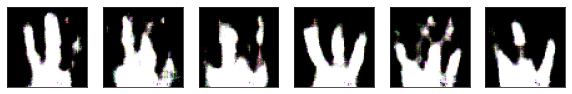

  0%|          | 0/11 [00:00<?, ?it/s]

[76/100][11/11]
Loss_D: 1.0792	Loss_G: -0.0129
D(x): 0.4453	D(G(z)): 0.1747 / 0.3297


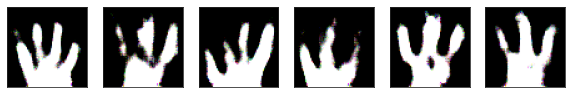

  0%|          | 0/11 [00:00<?, ?it/s]

[77/100][11/11]
Loss_D: 1.1475	Loss_G: 0.7650
D(x): 0.4847	D(G(z)): 0.2150 / 0.1726


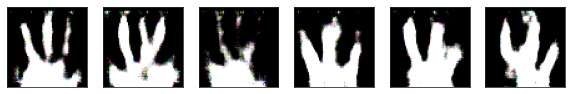

  0%|          | 0/11 [00:00<?, ?it/s]

[78/100][11/11]
Loss_D: 1.1989	Loss_G: 0.3975
D(x): 0.3159	D(G(z)): 0.1660 / 0.2444


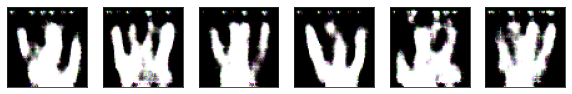

  0%|          | 0/11 [00:00<?, ?it/s]

[79/100][11/11]
Loss_D: 1.0178	Loss_G: 0.6680
D(x): 0.5991	D(G(z)): 0.1458 / 0.1135


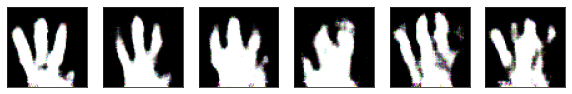

  0%|          | 0/11 [00:00<?, ?it/s]

[80/100][11/11]
Loss_D: 1.1079	Loss_G: 0.1603
D(x): 0.3243	D(G(z)): 0.1105 / 0.2566


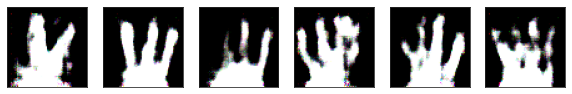

  0%|          | 0/11 [00:00<?, ?it/s]

[81/100][11/11]
Loss_D: 0.9516	Loss_G: 0.3463
D(x): 0.4167	D(G(z)): 0.1063 / 0.1827


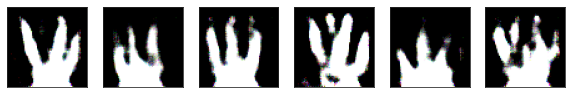

  0%|          | 0/11 [00:00<?, ?it/s]

[82/100][11/11]
Loss_D: 1.0077	Loss_G: 0.7381
D(x): 0.6423	D(G(z)): 0.2302 / 0.0944


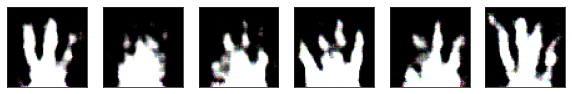

  0%|          | 0/11 [00:00<?, ?it/s]

[83/100][11/11]
Loss_D: 0.8347	Loss_G: 0.7210
D(x): 0.6489	D(G(z)): 0.1536 / 0.1076


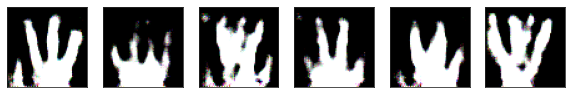

  0%|          | 0/11 [00:00<?, ?it/s]

[84/100][11/11]
Loss_D: 0.9493	Loss_G: 0.1630
D(x): 0.4035	D(G(z)): 0.0612 / 0.4238


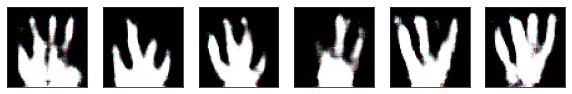

  0%|          | 0/11 [00:00<?, ?it/s]

[85/100][11/11]
Loss_D: 1.2037	Loss_G: -0.1326
D(x): 0.2400	D(G(z)): 0.0711 / 0.4557


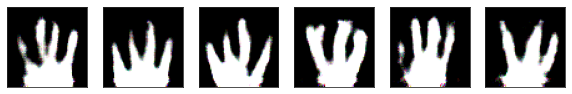

  0%|          | 0/11 [00:00<?, ?it/s]

[86/100][11/11]
Loss_D: 1.0684	Loss_G: 0.3176
D(x): 0.5170	D(G(z)): 0.2680 / 0.1733


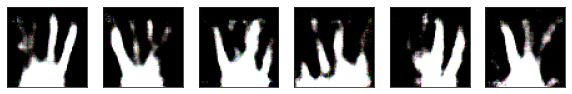

  0%|          | 0/11 [00:00<?, ?it/s]

[87/100][11/11]
Loss_D: 1.0074	Loss_G: 0.5250
D(x): 0.4283	D(G(z)): 0.1617 / 0.1828


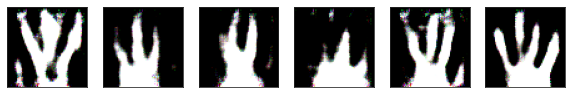

  0%|          | 0/11 [00:00<?, ?it/s]

[88/100][11/11]
Loss_D: 0.9632	Loss_G: 0.4682
D(x): 0.4728	D(G(z)): 0.1843 / 0.2119


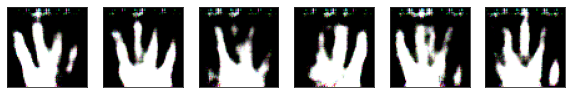

  0%|          | 0/11 [00:00<?, ?it/s]

[89/100][11/11]
Loss_D: 1.0061	Loss_G: -0.2840
D(x): 0.3985	D(G(z)): 0.0930 / 0.4949


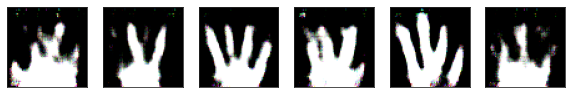

  0%|          | 0/11 [00:00<?, ?it/s]

[90/100][11/11]
Loss_D: 1.2198	Loss_G: -0.2967
D(x): 0.2628	D(G(z)): 0.0611 / 0.5385


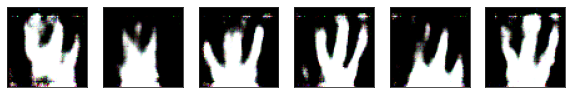

  0%|          | 0/11 [00:00<?, ?it/s]

[91/100][11/11]
Loss_D: 1.0237	Loss_G: 0.8106
D(x): 0.3887	D(G(z)): 0.1182 / 0.1776


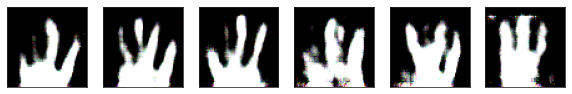

  0%|          | 0/11 [00:00<?, ?it/s]

[92/100][11/11]
Loss_D: 0.7805	Loss_G: 1.3554
D(x): 0.6488	D(G(z)): 0.1113 / 0.0432


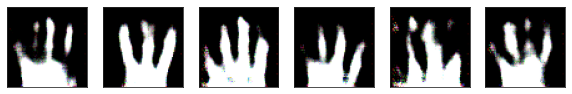

  0%|          | 0/11 [00:00<?, ?it/s]

[93/100][11/11]
Loss_D: 1.0601	Loss_G: 0.2746
D(x): 0.4128	D(G(z)): 0.1896 / 0.2478


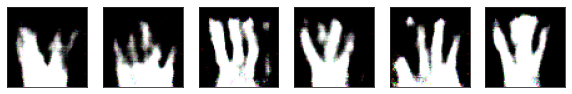

  0%|          | 0/11 [00:00<?, ?it/s]

[94/100][11/11]
Loss_D: 1.1409	Loss_G: 0.8607
D(x): 0.5350	D(G(z)): 0.3147 / 0.0981


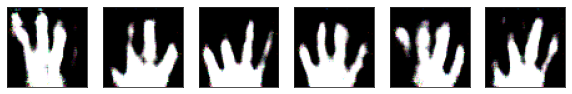

  0%|          | 0/11 [00:00<?, ?it/s]

[95/100][11/11]
Loss_D: 0.9265	Loss_G: 0.0396
D(x): 0.3641	D(G(z)): 0.0461 / 0.3638


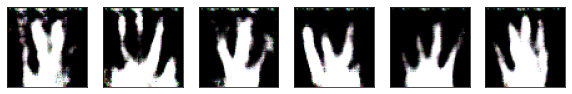

  0%|          | 0/11 [00:00<?, ?it/s]

[96/100][11/11]
Loss_D: 1.1776	Loss_G: 0.6776
D(x): 0.4218	D(G(z)): 0.1625 / 0.1279


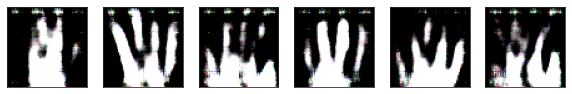

  0%|          | 0/11 [00:00<?, ?it/s]

[97/100][11/11]
Loss_D: 0.9542	Loss_G: 0.2750
D(x): 0.5422	D(G(z)): 0.1913 / 0.2094


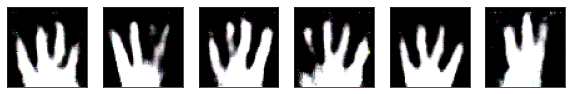

  0%|          | 0/11 [00:00<?, ?it/s]

[98/100][11/11]
Loss_D: 1.1907	Loss_G: 1.2669
D(x): 0.5730	D(G(z)): 0.2980 / 0.0891


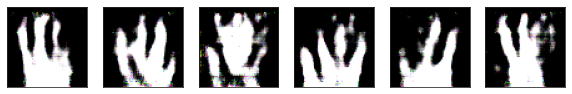

  0%|          | 0/11 [00:00<?, ?it/s]

[99/100][11/11]
Loss_D: 0.9861	Loss_G: 0.0471
D(x): 0.3532	D(G(z)): 0.1114 / 0.3084


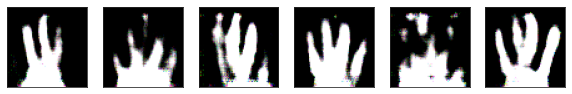

  0%|          | 0/11 [00:00<?, ?it/s]

[100/100][11/11]
Loss_D: 1.0755	Loss_G: 0.2223
D(x): 0.4486	D(G(z)): 0.1284 / 0.2487


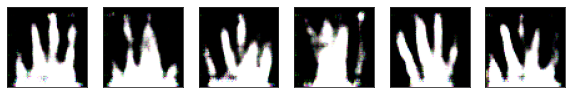

In [ ]:

Gen_losses = []
Dis_losses = []
Dis_acc = []
Gen_acc =[]
print("Starting Training Loop...")
for epoch in range(100):
    for i, data in enumerate(tqdm(dataloader)):
        real_label = data[1].to(device)
        real_image = data[0].to(device)
        b_size = real_label.size(0)     
        fake_label = torch.randint(number_of_class, (b_size,), dtype=torch.long, device=device)
        noise = torch.randn(b_size, 128, 1, 1, device=device).squeeze(0)
        noise = concat_noise_label(noise, real_label, device)  
        fake_image = generator(noise)
        real_target = torch.full((b_size,), r_label, device=device)
        fake_target = torch.full((b_size,), f_label, device=device)
        
        
        # Update Discriminator
        
        discriminator.zero_grad()
        s_output, c_output = discriminator(real_image)
        real_target = real_target.view(-1,1)
        s_Diserror_real = s_criterion(s_output, real_target) 
        c_Diserror_real = c_criterion(c_output, real_label) 
        Diserror_real = s_Diserror_real + c_Diserror_real
        Diserror_real.backward()
        D_x = s_output.data.mean()
        s_output,c_output = discriminator(fake_image.detach())
        fake_target = fake_target.view(-1,1)
        s_Diserror_fake = s_criterion(s_output, fake_target.float()) 
        c_Diserror_fake = c_criterion(c_output, real_label) 
        Diserror_fake = s_Diserror_fake + c_Diserror_fake
        Diserror_fake.backward()
        D_G_z1 = s_output.data.mean()
        
        s_pred = s_output > 0.5
        c_pred = c_output.argmax(dim=1) == real_label
        d_acc = (c_pred.float()+s_pred.float()).mean()
        Dis_acc.append(d_acc.item())

        Diserror = s_Diserror_real + s_Diserror_fake
        optimizerD.step()        

        # Update Generator 

        generator.zero_grad()
        
        s_output,c_output = generator(fake_image)
        s_Generror = s_criterion(s_output, real_target) 
        c_Generror = c_criterion(c_output, real_label) 
        Generror = s_Generror+ c_Generror
        Generror.backward()
        D_G_z2 = s_output.data.mean()
        
        optimizerG.step()
        

        s_pred = s_output > 0.5
        c_pred = c_output.argmax(dim=1) == real_label
        g_acc = (c_pred.float()+s_pred.float()).mean()
        Gen_acc.append(g_acc.item())


        Gen_losses.append(Generror.item())
        Dis_losses.append(Diserror.item())
    
    print('[%d/%d][%d/%d]\nLoss_D: %.4f\tLoss_G: %.4f\nD(x): %.4f\tD(G(z)): %.4f / %.4f'
          % (epoch+1, 100, i+1, len(dataloader),
             Diserror.item(), Generror.item(), D_x, D_G_z1, D_G_z2))
    
    show_generated_img(6)

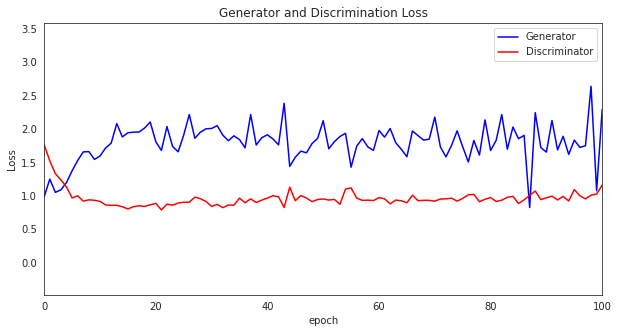

In [ ]:


show_loss(ylim=False)



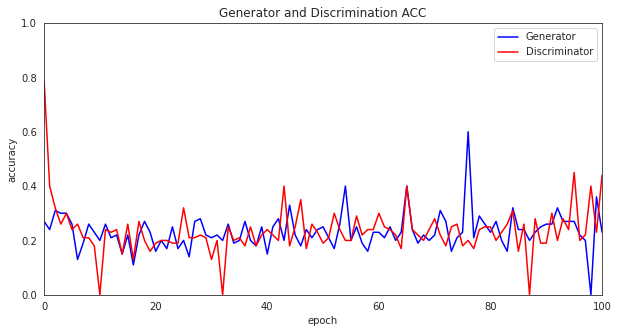

In [ ]:
show_acc(ylim=True)

In [ ]:
print("max accuracy generator: "+str(max(Gen_acc[0:100])))
print("max accuracy discriminator: "+str(max(Dis_acc[0:100])))

max accuracy generator: 0.5999999642372131
max accuracy discriminator: 0.7899999618530273
